## Data Cleaning 

In [21]:
# import librariesy 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [3]:
raw_df = pd.read_csv('~/Downloads/stack-overflow-bqresults.csv')

In [3]:
# raw_df.info()

In [4]:
# 80284 non-null types and title out of 250000 entries
# remove observations without tags or title 
raw_df.dropna(inplace=True)

In [5]:
# make remove html tags from body
raw_df['body'] = raw_df.body.apply(lambda x: BeautifulSoup(x).get_text())

### Digging through tags to find most popular tags (remove overlapping posts) 

In [6]:
# raw_df.tags.value_counts()[:50]

## We will focus on these 10 topics:

* git 
* android 
* javascript
* python 
* ruby
* c++
* c#
* java (make sure not overlap with c#)
* sql
* iphone 

In [7]:
all_tags = ['git','android','javascript','python',
               'ruby',"""c++""",'c#','java','sql','iphone']

In [8]:
def check_topic(L1, L2):
    '''
    inputs:
    L1: a list of strings, a list of tag words in the specific topic 
    L2: a list of strings, tags converted from the column tags as a list of strings 
    outputs:
    return True or False if the L2 tag contains key word from the L1 
    '''
    L2 = [x.lower() for x in L2]
    for l1 in L1:
        if l1.lower() in L2:
            return True
    return False

In [9]:
# create a function to check overlapping tags and remove them if so 

def overlap(tags):
    '''
    list of all tags of interest (look for specific tags)
    '''
    df = raw_df.copy()
    remain_tags = set(tags)
    for t1 in tags:
        remain_tags.remove(t1)
        # print(t1)
        for t in remain_tags:
            # print(t)
            mask = df.tags.str.split('|').apply(lambda x:
                                             check_topic([t1],x) and
                                             check_topic([t],x))
            # print (mask.sum())
            if mask.sum():  # common tags 
                # remove the repeating tags from the dataframe 
                # print(df.shape[0])
                df = df[~mask]
                # print(df.shape[0])
    return df            

### remove overlaping tags

In [10]:
filtered_df = overlap(all_tags)

In [11]:
filtered_df.shape

(79001, 4)

In [12]:
filtered_df.head()

,id,title,body,tags
5,927358,How do you undo the last commit?,I committed the wrong files to Git. How can I ...,git|git-commit|git-reset|git-revert
11,179123,Edit an incorrect commit message in Git,I wrote the wrong thing in a commit message. H...,git|git-commit|git-rewrite-history|amend
12,2003505,Delete a Git branch both locally and remotely,I want to delete a branch both locally and on ...,git|github|git-branch|git-remote
21,477816,What is the correct JSON content type?,I've been messing around with JSON for some ti...,json|content-type
23,292357,What are the differences between 'git pull' an...,What are the differences between git pull and ...,git|git-pull|git-fetch


### Select each tags and look at distribution

In [13]:
# change the tag names to these tags
for tag in all_tags:
    mask = filtered_df.tags.str.split('|').apply(lambda x:
                                                check_topic([tag], x))
    filtered_df.tags[mask] = tag

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
# remove any data that are not any of these tags 
filtered_df = filtered_df[filtered_df.tags.str.split('|').apply(lambda x: check_topic(all_tags,x))]

In [15]:
tags_info = filtered_df.tags.value_counts()

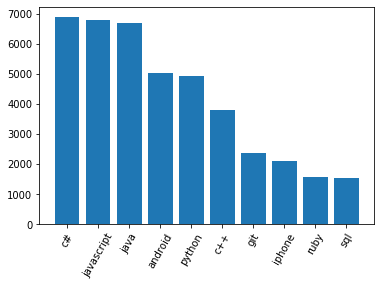

In [16]:
plt.bar(tags_info.index, tags_info.values)
plt.xticks(rotation=60)
plt.show()

In [17]:
# save the filtered_df for text preprocessing 
filtered_df.to_pickle('data/filtered_df.pkl')